# Applying Classification Modeling
The goal of this week's assessment is to find the model which best predicts whether a person will default on their loan. In doing so, we want to utilize all of the different tools we have learned over the course: data cleaning, EDA, feature engineering/transformation, feature selection, hyperparameter tuning, and model evaluation. 

Dataset: The dataset comes customers default payments in Taiwan. More information about the dataset and columns are found in the link below.

https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#


You will fit three different models (KNN, Logistic Regression, and Decision Tree Classifier) and use gridsearch to find the best hyperparameters for those models. Then you will compare the performance of those three models on a test set to find the best one.  


## Process/Expectations

#### You will be working in pairs for this assessment; please have ONE notebook and be prepared to explain how you worked in your pair.
1. Clean up your data set so that you can do EDA. This includes handling null values, categorical variables, removing unimportant columns, and removing outliers.
2. Perform EDA to identify opportunities to create new features.
    - [Great Example of EDA for classification](https://www.kaggle.com/stephaniestallworth/titanic-eda-classification-end-to-end) 
    - [Using Pairplots with Classification](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166)
3. Create polynomial and/or interaction features. You must also create at least 2 new features that are not interactions or polynomial transformations. For example, you can create a new dummy variable that based on the value of a continuous variable (billamount6 >2000) or take the average of some past amounts.
4. Perform some feature selction. This can happen beforehand using F-scores, or you can do it as part of your model building process by looking at the weights of your regularized logistic regression or feature importance of your decision tree.  
5. You must fit each of the three models to your data and tune at least 1 hyperparameter per model. 
6. After identifying the best hyperparameters for each model, fit those models to the test set and identify the best model overall using the evaluation metric of your choice.
7. Present your best model.

In [1]:
# import external libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# import py files.
from data_cleaning import *
from random_lumberjacks.src.random_lumberjacks.model.model_classes import *
from random_lumberjacks.src.random_lumberjacks.visualization.visualization_functions import *

# Configure matplotlib for jupyter.
%matplotlib inline

/home/corey/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1. Data Cleaning

In [2]:
df = pd.read_csv('student_data.csv')

In [3]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [4]:
# df.rename(columns={"PAY_0":"PAY_1"}, inplace=True)

#Imputes values to combine "other"/"unknown" fields in the marriage and education columns.
df= replace_unknowns(df)

## 2. EDA

In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,23999.0,15027.353931,8654.746941,1.0,7506.0,15027.0,22531.5,30000.0
LIMIT_BAL,23999.0,167825.729405,129915.115993,10000.0,50000.0,140000.0,240000.0,1000000.0
SEX,23999.0,1.603608,0.489158,1.0,1.0,2.0,2.0,2.0
EDUCATION,23999.0,1.783408,0.730617,0.0,1.0,2.0,2.0,3.0
MARRIAGE,23999.0,1.517897,0.524588,0.0,1.0,2.0,2.0,2.0
AGE,23999.0,35.523230,9.253986,21.0,28.0,34.0,42.0,79.0
PAY_1,23999.0,-0.014959,1.120903,-2.0,-1.0,0.0,0.0,8.0
PAY_2,23999.0,-0.134839,1.193044,-2.0,-1.0,0.0,0.0,8.0
PAY_3,23999.0,-0.165632,1.193515,-2.0,-1.0,0.0,0.0,8.0
PAY_4,23999.0,-0.217092,1.168719,-2.0,-1.0,0.0,0.0,8.0


<Figure size 1440x1080 with 0 Axes>

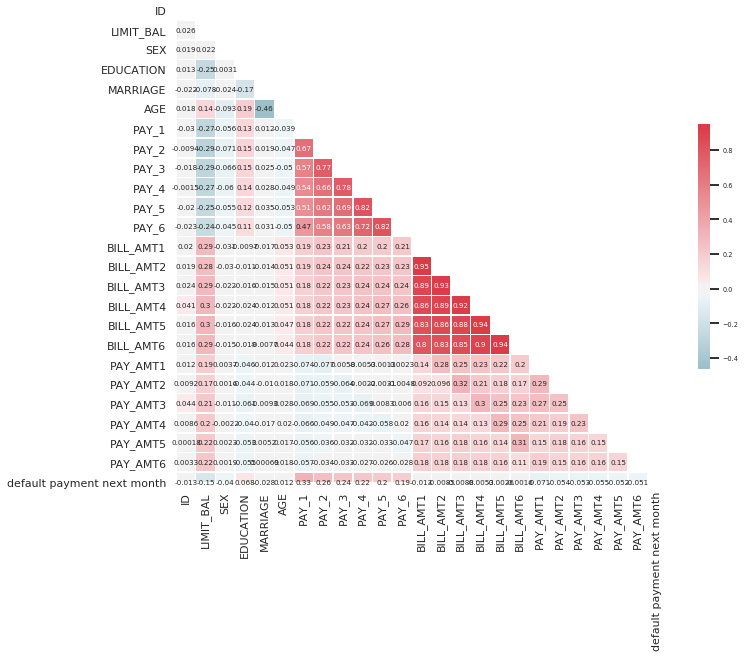

In [5]:
trimmed_heatmap(df, df.columns, font_scale=.4, figsize=(20,15))
# trimmed_heatmap(df, selection, font_scale=.4, figsize=(20,15))

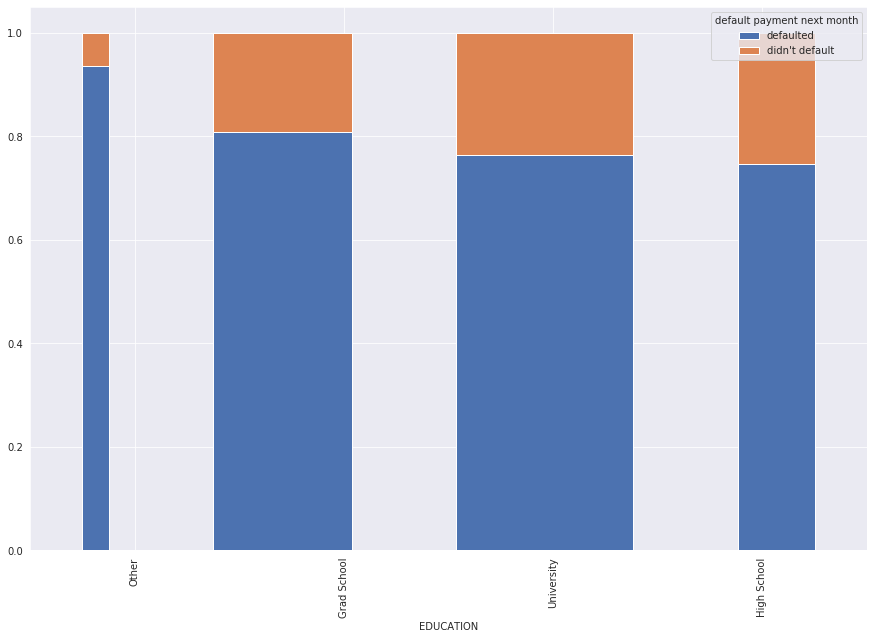

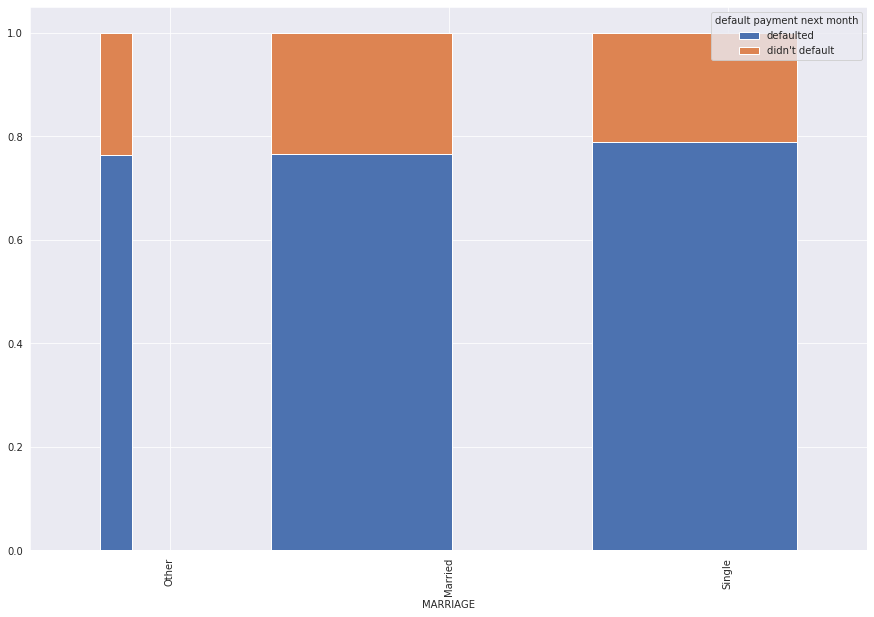

In [6]:
edu_dict = {1:'Grad School' , 2:'University' , 3:'High School' , 0:'Other'}
marriage_dict = {1:'Married' , 2:'Single' , 0:'Other'}
visualize = df.copy()
visualize['default payment next month'] = np.where(df['default payment next month'] ==0, "defaulted", "didn't default")
plot_stacked_proportion(visualize, "EDUCATION", 'default payment next month', .2, x_dict=edu_dict, palette="deep")
plot_stacked_proportion(visualize, "MARRIAGE", 'default payment next month', .2, x_dict=marriage_dict, palette="deep")

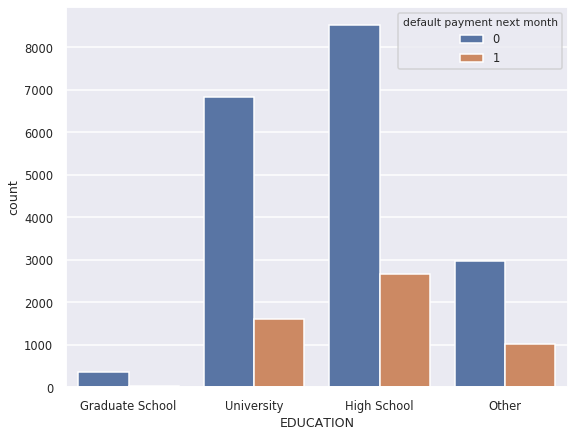

In [31]:
# EDA for education vs default payment
sns.set(rc = {'figure.figsize':(9,7)})
sns.set_context('talk' , font_scale=0.7)
edu = sns.countplot(x = 'EDUCATION'  ,hue='default payment next month', data = df)
edu.set_xticklabels(['Graduate School' , 'University' , 'High School' , 'Other'])
plt.show()

In [ ]:
graph = Multiplot(df[selection], 3, figsize=(15,25))
graph.sb_multiplot(sns.boxplot)
# graph.sb_qq_plots(scat_kwargs)
# graph.sb_multiplot(sns.scatterplot, scat_kwargs, default_axis="x")

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,PAY_2N1,PAY_2N2,PAY_3N1,PAY_3N2,PAY_4N1,PAY_4N2,PAY_5N1,PAY_5N2,PAY_6N1,PAY_6N2
0,2873.0,350000.0,1.0,1.0,2.0,37.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3598.0,50000.0,2.0,2.0,1.0,37.0,2,2,2,0,...,0,0,0,0,0,0,0,0,0,0
2,27623.0,50000.0,2.0,1.0,2.0,23.0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
3,6874.0,20000.0,1.0,3.0,1.0,56.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6444.0,110000.0,2.0,2.0,2.0,32.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23994,7886.0,50000.0,2.0,1.0,2.0,24.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23995,7750.0,250000.0,1.0,3.0,1.0,44.0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
23996,14379.0,50000.0,1.0,3.0,2.0,26.0,2,0,0,2,...,0,0,0,0,0,0,0,0,0,0
23997,23664.0,110000.0,2.0,2.0,1.0,38.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 3. Feature Engineering

In [5]:
df = calculate_utilization(df)
df = combine_pay_columns(df)
df = split_pay_columns(df)

## 4. Feature Selection

In [7]:
chart = df1.groupby("PAY_1").mean().reset_index()
chart["default payment next month"] = chart["default payment next month"].map(lambda x: math.log(x/(1-x)))
sns.scatterplot(x="PAY_1", y="default payment next month", data=chart)


NameError: name 'df1' is not defined

In [6]:
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,BILL_AMT1,BILL_AMT2,BILL_AMT3,...,payment_impact4,utilization4,payment_impact5,utilization5,payment_impact6,utilization6,debt_avg_delta,payment_improvements,PAY_0N1,PAY_0N2
0,2873.0,350000.0,1.0,1.0,2.0,37.0,0,316.0,316.0,316.0,...,0.001331,0.001331,0.000903,0.001331,0.000903,0.000903,0.000000,0.0,0,0
1,3598.0,50000.0,2.0,2.0,1.0,37.0,2,40994.0,43594.0,38222.0,...,0.012000,0.260520,0.012000,0.265360,0.012000,0.269940,0.000000,0.0,0,0
2,27623.0,50000.0,2.0,1.0,2.0,23.0,0,3430.0,2478.0,2299.0,...,0.196200,0.096000,0.013200,0.196200,0.059600,0.013200,0.011310,0.0,1,1
3,6874.0,20000.0,1.0,3.0,1.0,56.0,0,10847.0,12176.0,12884.0,...,0.000000,0.689200,0.024500,0.671000,0.032900,0.684300,0.000000,1.0,0,0
4,6444.0,110000.0,2.0,2.0,2.0,32.0,0,108159.0,106812.0,108464.0,...,0.037273,0.989355,0.037273,1.005064,0.038182,0.964382,0.012245,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23994,7886.0,50000.0,2.0,1.0,2.0,24.0,0,12806.0,13490.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0,0
23995,7750.0,250000.0,1.0,3.0,1.0,44.0,0,6826.0,3900.0,4482.0,...,0.152664,0.174184,0.002304,0.152204,0.009556,0.002304,0.011704,0.0,1,1
23996,14379.0,50000.0,1.0,3.0,2.0,26.0,2,41827.0,42650.0,45930.0,...,0.070000,0.897820,0.040000,0.953080,0.000000,0.974420,0.000000,0.0,0,0
23997,23664.0,110000.0,2.0,2.0,1.0,38.0,0,195437.0,176420.0,63142.0,...,0.018182,0.362309,0.363255,0.084482,0.472727,-0.011709,0.357682,0.0,0,0


In [19]:
(df["PAY_1"].values < df["PAY_2"].values).astype(int) + (df["PAY_1"].values < df["PAY_2"].values).astype(int)

array([0, 0, 0, ..., 0, 0, 2])

In [11]:
df.head[["PAY_1"]](50)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,PAY_2N1,PAY_2N2,PAY_3N1,PAY_3N2,PAY_4N1,PAY_4N2,PAY_5N1,PAY_5N2,PAY_6N1,PAY_6N2
0,2873.0,350000.0,1.0,1.0,2.0,37.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3598.0,50000.0,2.0,2.0,1.0,37.0,2,2,2,0,...,0,0,0,0,0,0,0,0,0,0
2,27623.0,50000.0,2.0,1.0,2.0,23.0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
3,6874.0,20000.0,1.0,3.0,1.0,56.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6444.0,110000.0,2.0,2.0,2.0,32.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,16729.0,50000.0,1.0,2.0,1.0,32.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,20303.0,240000.0,2.0,2.0,1.0,53.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,29286.0,360000.0,1.0,2.0,2.0,26.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,20119.0,240000.0,2.0,1.0,2.0,33.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,20740.0,240000.0,1.0,1.0,2.0,30.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
excluded = exclude_columns(["PAY_AMT", "BILL_AMT", "payment_impact","utilization"], 1, 7)
excluded2 = exclude_columns(["PAY_"], 2, 7)
selection = df.drop(columns = [*excluded, *excluded2]).columns
df_trimmed = df[selection]

# df.to_pickle("df_untrimmed.pickle")
# df_trimmed.to_pickle("df_trimmed.pickle")

In [7]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month', 'avg_utilization', 'avg_payment_impact',
       'debt_streak', 'payment_impact1', 'utilization1', 'payment_impact2',
       'utilization2', 'payment_impact3', 'utilization3', 'payment_impact4',
       'utilization4', 'payment_impact5', 'utilization5', 'payment_impact6',
       'utilization6', 'debt_avg_delta', 'payment_improvements', 'PAY_0N1',
       'PAY_0N2'],
      dtype='object')

In [8]:
#Creating column selection dictionaries for the data from lists of column names.

#Lists to go in the dictionaries.
nom = ["SEX", "EDUCATION", "MARRIAGE",]
reg_dummies = []
pay_dummies=["PAY_0N1", "PAY_0N2"]
untr = ["LIMIT_BAL", "avg_utilization", "avg_payment_impact", "debt_streak",
        "debt_avg_delta","PAY_0",'payment_improvements']
# tran = {"logged": {"ID":20,}
tran = {}
polyc = ["avg_utilization", "avg_payment_impact", "PAY_1",]

#The dicts that come into the arguments.
target_col = "default payment next month"
categorical = {
    "nominal_features":nom, "standard_dummies":reg_dummies, "impute_dummies":pay_dummies
}

continuous = {"untransformed":untr, "transformed": tran}
polynomial = {"method":"all", "columns":polyc}

## 5. Model Fitting and Hyperparameter Tuning
KNN, Logistic Regression, Decision Tree

In [9]:
data = DataPreprocessor(df, target_col, categorical, continuous, polynomial, True, True,random_state=124)
data.data_preprocessing(balance_class="upsample", scale_type="minmax", poly_degree=False)
data.get_X_test()

Creating Dummies
Skipping polynomial features
Performing upsample
Using Min/Max scaler


,LIMIT_BAL,avg_utilization,avg_payment_impact,debt_streak,debt_avg_delta,PAY_0,payment_improvements,PAY_0N1,PAY_0N2,SEX_2.0,EDUCATION_1.0,EDUCATION_2.0,EDUCATION_3.0,MARRIAGE_1.0,MARRIAGE_2.0
3770,0.111111,0.143336,0.149710,0.2,0.000219,0.000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3858,0.101010,0.188015,0.198034,0.2,0.019759,0.000,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
12572,0.040404,0.124567,0.038829,0.0,0.000000,0.000,0.2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
9082,0.202020,0.057710,0.041475,0.2,0.043966,0.000,0.6,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
6032,0.494949,0.037852,0.013548,0.0,0.000000,0.000,0.2,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21466,0.020202,0.147437,0.047694,0.0,0.000000,0.125,0.8,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
20732,0.101010,0.136383,0.121012,0.0,0.000000,0.000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
20917,0.333333,0.113693,0.023206,0.0,0.000000,0.000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
23051,0.181818,0.155423,0.030555,0.0,0.000000,0.250,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


In [49]:
full_value_counts(df, target_col)

There are 2 unique values with 0 nan values making up 0.0%
18691-0.0 --77.88%
5308-1.0 --22.12%


In [11]:
logreg = LogisticRegression(fit_intercept=False, C=1e12,
                            solver='liblinear', random_state=data.random_state)
model_log = logreg.fit(data.X_train, data.y_train)
model_log

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=124, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

## 6. Model Evaluation

In [12]:
evaluate_model(model_log, data.X_train, data.y_train)
print()
evaluate_model(model_log, data.X_test, data.y_test)

F1 Score: 0.6485510031516644
Accuracy: 0.6934629567549447
Precision: 0.7598847158425651
Recall: 0.5656721421387865
Params:
{'C': 1000000000000.0, 'class_weight': None, 'dual': False, 'fit_intercept': False, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 124, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

F1 Score: 0.5194805194805194
Accuracy: 0.76875
Precision: 0.4665629860031104
Recall: 0.5859375
Params:
{'C': 1000000000000.0, 'class_weight': None, 'dual': False, 'fit_intercept': False, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 124, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [52]:
knn=KNeighborsClassifier(n_neighbors=12)
knn.fit(data.X_train,data.y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=12, p=2,
                     weights='uniform')

In [16]:
evaluate_model(knn, data.X_test, data.y_test)

F1 Score: 0.46334979111279906
Accuracy: 0.705625
Precision: 0.3791174642635177
Recall: 0.595703125
Params:
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 12, 'p': 2, 'weights': 'uniform'}


In [24]:
forest = RandomForestClassifier(n_estimators=200, max_depth=5, criterion='gini',
                                random_state=data.random_state, n_jobs=-1,)
forest.fit(data.X_train, data.y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=124, verbose=0,
                       warm_start=False)

In [25]:
evaluate_model(forest, data.X_test, data.y_test)

F1 Score: 0.5312072892938497
Accuracy: 0.785625
Precision: 0.49786507258753204
Recall: 0.5693359375
Params:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': -1, 'oob_score': False, 'random_state': 124, 'verbose': 0, 'warm_start': False}


In [26]:
xg_clf=xgb.XGBClassifier(random_state=data.random_state)

In [27]:
xg_clf.fit(data.X_train, data.y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=124, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [28]:
evaluate_model(xg_clf, data.X_test, data.y_test)

F1 Score: 0.5106753812636167
Accuracy: 0.7660416666666666
Precision: 0.46105428796223447
Recall: 0.572265625
Params:
{'objective': 'binary:logistic', 'base_score': 0.5, 'booster': None, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 124, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': None, 'validate_parameters': False, 'verbosity': None}


## 7. Final Model